In [1]:
%matplotlib inline

from pathlib import Path
import shutil

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import sys
sys.path.append("../")
import maskflow

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/Shapes")
data_dir = root_dir / "Data"
log_dir = root_dir / "Logs"

# Import the configuration associated with this dataset
config = maskflow.load_config(root_dir / "config.yml")
model_basename = config["NAME"]
model_dir = log_dir / model_basename
saved_model_dir = root_dir / "SavedModels" / model_basename

Using TensorFlow backend.


# Prepare dataset

This step should be adapted to your usecase. The important is to return a tuple of dict with the following signature: `{"images": Tensor, "masks": Tensor}, {"class_ids": Tensor}`.

In [2]:
batch_size = 2

# Get paths
image_paths = np.array([str(fname) for fname in sorted(data_dir.glob("*_original.tif"))])
mask_paths = np.array([str(fname) for fname in sorted(data_dir.glob("*_mask.tif"))])
class_ids_paths = np.array([str(fname) for fname in sorted(data_dir.glob("*_class_ids.csv"))])

# Split training and evaluation dataset
train_indices, eval_indices = train_test_split(np.arange(0, len(image_paths)), train_size=0.8)

# Training dataset
image_paths_train = image_paths[train_indices]
mask_paths_train = mask_paths[train_indices]
class_ids_paths_train = class_ids_paths[train_indices]

# Evaluation dataset
image_paths_eval = image_paths[eval_indices]
mask_paths_eval = mask_paths[eval_indices]
class_ids_paths_eval = class_ids_paths[eval_indices]

def input_fn(image_paths, mask_paths, class_ids_paths, batch_size, max_objects, shuffle=True, repeat=False):
    def _input_fn():
        dataset = maskflow.load_dataset_from_paths(image_paths, mask_paths, class_ids_paths,
                                                   max_objects=max_objects, shuffle=shuffle)
        if repeat:
            dataset = dataset.repeat()
        
        dataset = dataset.prefetch(2 * batch_size)
        dataset = dataset.batch(batch_size)

        iterator = dataset.make_one_shot_iterator()
        images, masks, class_ids = iterator.get_next()
        
        inputs = {}
        inputs["images"] = images
        inputs["image_height"] = tf.constant(200, dtype=tf.int32)
        inputs["image_width"] = tf.constant(200, dtype=tf.int32)
        inputs["image_channel"] = tf.constant(3, dtype=tf.int32)
        
        outputs = {}
        outputs["class_ids"] = class_ids
        outputs["masks"] = masks
        
        return inputs, outputs
    return _input_fn

/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Visualize dataset

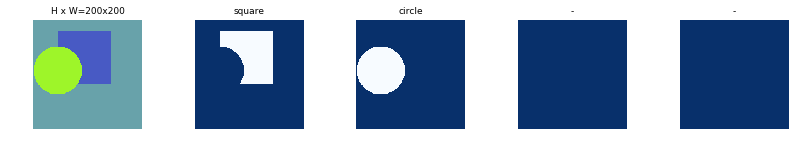

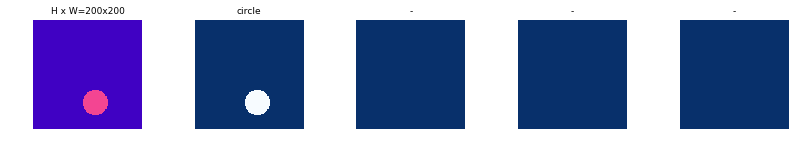

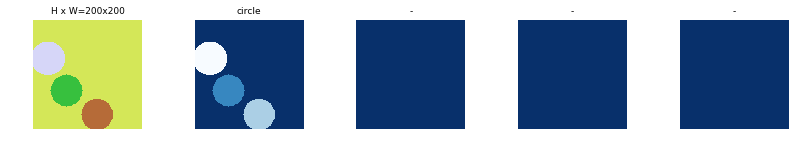

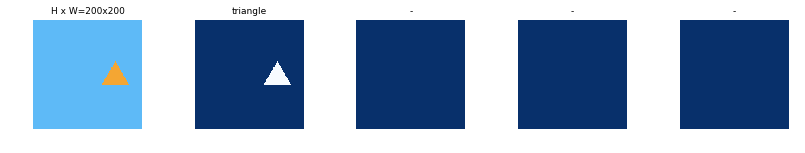

In [3]:
example_dataset = input_fn(image_paths, mask_paths, class_ids_paths, batch_size, config["MAX_OBJECTS"], shuffle=True)()

with tf.Session() as sess:
    for i in range(2):
        features, labels = sess.run(example_dataset)
        _ = maskflow.display_top_masks(features["images"], labels["masks"],
                                       labels["class_ids"], config["CLASS_NAMES"])

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import keras.layers as KL
import keras.engine as KE

############################################################
#  Proposal Layer
############################################################

def apply_box_deltas_graph(boxes, deltas):
    """Applies the given deltas to the given boxes.
    boxes: [N, (y1, x1, y2, x2)] boxes to update
    deltas: [N, (dy, dx, log(dh), log(dw))] refinements to apply
    """
    # Convert to y, x, h, w
    height = boxes[:, 2] - boxes[:, 0]
    width = boxes[:, 3] - boxes[:, 1]
    center_y = boxes[:, 0] + 0.5 * height
    center_x = boxes[:, 1] + 0.5 * width
    
    # Apply deltas
    center_y += deltas[:, 0] * height
    center_x += deltas[:, 1] * width
    height *= tf.exp(deltas[:, 2])
    width *= tf.exp(deltas[:, 3])
    
    # Convert back to y1, x1, y2, x2
    y1 = center_y - 0.5 * height
    x1 = center_x - 0.5 * width
    y2 = y1 + height
    x2 = x1 + width
    result = tf.stack([y1, x1, y2, x2], axis=1, name="apply_box_deltas_out")
    return result


def clip_boxes_graph(boxes, window):
    """
    boxes: [N, (y1, x1, y2, x2)]
    window: [4] in the form y1, x1, y2, x2
    """
    # Split
    wy1, wx1, wy2, wx2 = tf.split(window, 4)
    y1, x1, y2, x2 = tf.split(boxes, 4, axis=1)
    
    # Clip
    y1 = tf.maximum(tf.minimum(y1, wy2), wy1)
    x1 = tf.maximum(tf.minimum(x1, wx2), wx1)
    y2 = tf.maximum(tf.minimum(y2, wy2), wy1)
    x2 = tf.maximum(tf.minimum(x2, wx2), wx1)
    clipped = tf.concat([y1, x1, y2, x2], axis=1, name="clipped_boxes")
    clipped.set_shape((clipped.shape[0], 4))
    return clipped


class ProposalLayer2(KE.Layer):
    """Receives anchor scores and selects a subset to pass as proposals
    to the second stage. Filtering is done based on anchor scores and
    non-max suppression to remove overlaps. It also applies bounding
    box refinement deltas to anchors.
    Inputs:
        rpn_probs: [batch, anchors, (bg prob, fg prob)]
        rpn_bbox: [batch, anchors, (dy, dx, log(dh), log(dw))]
        anchors: [batch, (y1, x1, y2, x2)] anchors in normalized coordinates
    Returns:
        Proposals in normalized coordinates [batch, rois, (y1, x1, y2, x2)]
    """

    def __init__(self, proposal_count, nms_threshold, rpn_bbox_std_dev, **kwargs):
        super().__init__(**kwargs)
        self.rpn_bbox_std_dev = rpn_bbox_std_dev
        self.proposal_count = proposal_count
        self.nms_threshold = nms_threshold

    def call(self, inputs):
        # Box Scores. Use the foreground class confidence. [Batch, num_rois, 1]
        scores = tf.cast(inputs[0][:, :, 1], dtype=tf.float32)
        
        # Box deltas [batch, num_rois, 4]
        deltas = inputs[1]
        deltas = tf.cast(deltas * np.reshape(self.rpn_bbox_std_dev, [1, 1, 4]), dtype=tf.float32)
        
        # Anchors
        anchors = tf.cast(inputs[2], dtype=tf.float32)

        # Improve performance by trimming to top anchors by score
        # and doing the rest on the smaller subset.
        pre_nms_limit = tf.minimum(6000, tf.shape(anchors)[1])
        ix = tf.nn.top_k(scores, pre_nms_limit, sorted=True, name="top_anchors").indices
        ix = tf.cast(ix, dtype=tf.float32)
        print(scores)
        
        scores = tf.map_fn(lambda xy: tf.gather(xy[0], tf.cast(xy[1], dtype=tf.int32)),
                           tf.stack([scores, ix], axis=1))
        
        deltas = tf.map_fn(lambda xy: tf.gather(xy[0], tf.cast(xy[1], dtype=tf.int32)),
                           tf.stack([deltas, ix], axis=1))
        
        pre_nms_anchors = tf.map_fn(lambda ax: tf.gather(ax[0], tf.cast(a[1], dtype=tf.int32)),
                                    tf.stack([anchors, ix], axis=1),
                                    name="pre_nms_anchors")

        # Apply deltas to anchors to get refined anchors.
        # [batch, N, (y1, x1, y2, x2)]
        boxes = tf.map_fn(lambda xy: apply_box_deltas_graph(xy[0], xy[1]),
                          tf.stack([pre_nms_anchors, deltas], axis=1),
                          name="refined_anchors")

        # Clip to image boundaries. Since we're in normalized coordinates,
        # clip to 0..1 range. [batch, N, (y1, x1, y2, x2)]
        window = np.array([0, 0, 1, 1], dtype=np.float32)
        boxes = tf.map_fn(lambda x: clip_boxes_graph(x, window),
                          boxes,
                          name="refined_anchors_clipped")

        # Filter out small boxes
        # According to Xinlei Chen's paper, this reduces detection accuracy
        # for small objects, so we're skipping it.

        # Non-max suppression
        def nms(inputs):
            boxes = inputs[0]
            scores = inputs[1]
            indices = tf.image.non_max_suppression(boxes,
                                                   scores,
                                                   self.proposal_count,
                                                   self.nms_threshold,
                                                   name="rpn_non_max_suppression")
            proposals = tf.gather(boxes, indices)
            
            # Pad if needed
            padding = tf.maximum(self.proposal_count - tf.shape(proposals)[0], 0)
            proposals = tf.pad(proposals, [(0, padding), (0, 0)])
            return proposals
        
        proposals = tf.map_fn(nms, tf.stack([boxes, scores], axis=1))
        
        return proposals

    def compute_output_shape(self, input_shape):
        return (None, self.proposal_count, 4)

In [9]:
from tensorflow import keras
import keras.layers as KL

from maskflow import resnet_graph
from maskflow import build_rpn_model
from maskflow import ProposalLayer
from maskflow.graph import parse_image_meta_graph


def maskrcnn_model_fn(features, labels, mode, params):
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        tf.logging.info("Mask RCNN Model mode: prediction")
    elif mode == tf.estimator.ModeKeys.EVAL:
        tf.logging.info("Mask RCNN Model mode: evaluation")
    elif mode == tf.estimator.ModeKeys.TRAIN:
        tf.logging.info("Mask RCNN Model mode: training")
        
    h = features["image_height"]
    w = features["image_width"]
    c = features["image_channel"]
    
    if (params["IMAGE_MAX_DIM"] / 2**6) != int(params["IMAGE_MAX_DIM"] / 2**6):
        raise Exception("Image size must be dividable by 2 at least 6 times "
                        "to avoid fractions when downscaling and upscaling."
                        "For example, use 256, 320, 384, 448, 512, ... etc. ")
    
    n_classes = len(params["CLASS_NAMES"])
    max_objects = params["MAX_OBJECTS"]

    with tf.variable_scope("Preprocessing"):
        
        # Cast and reshape input images
        images = tf.cast(features["images"], tf.float16)
        images_shape = tf.cast((-1, h, w, c), tf.int32)
        images = tf.reshape(images, images_shape)
        batch_size = tf.shape(images)[0]
        
        # Get class ids and masks if not in predict mod
        if mode != tf.estimator.ModeKeys.PREDICT:
            class_ids = tf.cast(labels["class_ids"], tf.int32)
            class_ids = tf.reshape(class_ids, (batch_size, max_objects))
            class_id = class_ids[:, 0]
            
            masks = tf.cast(labels["masks"], tf.float16)
            masks = tf.reshape(masks, tf.stack((batch_size, h, w, -1)))
        else:
            class_ids = None
            masks = None
            
        # Preprocessing
        results = maskflow.preprocessing_graph(images, h, w, c, params)
        molded_images, window, image_meta, backbone_shapes, anchors = results

    with tf.variable_scope("Mask_RCNN_Model"):
        
        with tf.variable_scope("Resnet_Graph"):
            _, C2, C3, C4, C5 = resnet_graph(molded_images, params["BACKBONE"],
                                             stage5=True, train_bn=params["TRAIN_BN"])
        
        with tf.variable_scope("Feature_Pyramid_Network"):
            
            top_down_pyramid_size = params["TOP_DOWN_PYRAMID_SIZE"]
            
            # TODO: add assert to varify feature map sizes match what's in config
            P5 = KL.Conv2D(top_down_pyramid_size, (1, 1), name='fpn_c5p5')(C5)
            
            up = KL.UpSampling2D(size=(2, 2), name="fpn_p5upsampled")(P5)
            conv = KL.Conv2D(top_down_pyramid_size, (1, 1), name='fpn_c4p4')(C4)
            P4 = KL.Add(name="fpn_p4add")([up, conv])

            up = KL.UpSampling2D(size=(2, 2), name="fpn_p4upsampled")(P4)
            conv = KL.Conv2D(top_down_pyramid_size, (1, 1), name='fpn_c3p3')(C3)
            P3 = KL.Add(name="fpn_p3add")([up, conv])
            
            up = KL.UpSampling2D(size=(2, 2), name="fpn_p3upsampled")(P3)
            conv = KL.Conv2D(top_down_pyramid_size, (1, 1), name='fpn_c2p2')(C2)
            P2 = KL.Add(name="fpn_p2add")([up, conv])
            
            # Attach 3x3 conv to all P layers to get the final feature maps.
            P2 = KL.Conv2D(top_down_pyramid_size, (3, 3), padding="same", name="fpn_p2")(P2)
            P3 = KL.Conv2D(top_down_pyramid_size, (3, 3), padding="same", name="fpn_p3")(P3)
            P4 = KL.Conv2D(top_down_pyramid_size, (3, 3), padding="same", name="fpn_p4")(P4)
            P5 = KL.Conv2D(top_down_pyramid_size, (3, 3), padding="same", name="fpn_p5")(P5)
            
            # P6 is used for the 5th anchor scale in RPN. Generated by
            # subsampling from P5 with stride of 2.
            P6 = KL.MaxPooling2D(pool_size=(1, 1), strides=2, name="fpn_p6")(P5)

            # Note that P6 is used in RPN, but not in the classifier heads.
            rpn_feature_maps = [P2, P3, P4, P5, P6]
            mrcnn_feature_maps = [P2, P3, P4, P5]        
        
        with tf.variable_scope("Region_Proposal_Network"):
            
            rpn = build_rpn_model(params["RPN_ANCHOR_STRIDE"],
                                  len(params["RPN_ANCHOR_RATIOS"]),
                                  params["TOP_DOWN_PYRAMID_SIZE"])
            
            # Loop through pyramid layers
            layer_outputs = [rpn([p]) for p in rpn_feature_maps]
                
            # Concatenate layer outputs
            # Convert from list of lists of level outputs to list of lists
            # of outputs across levels.
            # e.g. [[a1, b1, c1], [a2, b2, c2]] => [[a1, a2], [b1, b2], [c1, c2]]
            output_names = ["rpn_class_logits", "rpn_class", "rpn_bbox"]
            outputs = list(zip(*layer_outputs))
            outputs = [KL.Concatenate(axis=1, name=n)(list(o)) for o, n in zip(outputs, output_names)]
            
            rpn_class_logits, rpn_class, rpn_bbox = outputs
            
            rpn_class_logits = tf.identity(rpn_class_logits, name="rpn_class_logits")
            rpn_class = tf.identity(rpn_class, name="rpn_class")
            rpn_bbox = tf.identity(rpn_bbox, name="rpn_bbox")
            
            with tf.variable_scope("Proposal_Layer"):
                # Generate proposals
                # Proposals are [batch, N, (y1, x1, y2, x2)] in normalized coordinates
                # and zero padded.
                proposal_count = tf.cond(tf.equal(mode, tf.estimator.ModeKeys.TRAIN),
                                         lambda: params["POST_NMS_ROIS_TRAINING"],
                                         lambda: params["POST_NMS_ROIS_INFERENCE"])

                proposal_layer = ProposalLayer2(proposal_count,
                                               params["RPN_NMS_THRESHOLD"],
                                               params["RPN_BBOX_STD_DEV"],
                                               name="ROI")
                #rpn_rois = proposal_layer([rpn_class, rpn_bbox, anchors])
        
        """
        if mode == tf.estimator.ModeKeys.TRAIN:
            
            # Class ID mask to mark class IDs supported by the dataset the image
            # came from.
            active_class_ids = KL.Lambda(
                lambda x: parse_image_meta_graph(x)["active_class_ids"]
                )(input_image_meta)

            if not config.USE_RPN_ROIS:
                # Ignore predicted ROIs and use ROIs provided as an input.
                input_rois = KL.Input(shape=[config.POST_NMS_ROIS_TRAINING, 4],
                                      name="input_roi", dtype=np.int32)
                # Normalize coordinates
                target_rois = KL.Lambda(lambda x: norm_boxes_graph(
                    x, K.shape(input_image)[1:3]))(input_rois)
            else:
                target_rois = rpn_rois
                
        else:
            pass
        """
        
        

        predictions = {"rpn_class_logits": rpn_class_logits}

    # 1. Prediction mode
    if mode == tf.estimator.ModeKeys.PREDICT:
        predict_output = {"predict": tf.estimator.export.PredictOutput(predictions)}
        return tf.estimator.EstimatorSpec(mode, predictions=predictions,
                                          export_outputs=predict_output)
            
    with tf.variable_scope("Losses"):
        rpn_class_loss = KL.Lambda(lambda x: rpn_class_loss_graph(*x), name="rpn_class_loss")(
                [input_rpn_match, rpn_class_logits])

        # Calculate the accuracy between the true labels, and our predictions
        #accuracy = tf.metrics.accuracy(labels=class_id, predictions=predictions["class_ids"])

    # 2. Evaluation mode
    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(mode, loss=loss)#, eval_metric_ops={"accuracy": accuracy})

    # 3. Training mode
    with tf.variable_scope("Training"):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=params["learning_rate"])
        train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
        
    tf.summary.image("input_images", images)
    tf.summary.image("input_masks", tf.expand_dims(masks[:, :, :, 0], axis=-1))

    tf.summary.image("C2", C2)
    tf.summary.image("C3", C3)
    tf.summary.image("C4", C4)
    tf.summary.image("C5", C5)
    
    tf.summary.image("P2", P2)
    tf.summary.image("P3", P3)
    tf.summary.image("P4", P4)
    tf.summary.image("P5", P5)
    tf.summary.image("P6", P6)
        
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

# Training

In [10]:
tf.reset_default_graph()

# Training settings
n_epochs = 200
batch_size = 8
learning_rate = 0.0001
restore_checkpoint = False

train_size = len(image_paths_train)
eval_size = len(image_paths_eval)
steps_per_epoch = train_size // batch_size + 100
eval_steps = eval_size // batch_size
total_training_steps = steps_per_epoch * n_epochs

# Construct the estimator
run_config = tf.estimator.RunConfig(save_summary_steps=steps_per_epoch,
                                    save_checkpoints_steps=steps_per_epoch,
                                    log_step_count_steps=steps_per_epoch)

params = config.copy()
params["learning_rate"] = learning_rate
estimator = tf.estimator.Estimator(model_fn=maskrcnn_model_fn, model_dir=model_dir, params=params, config=run_config)

# Setup the dataset
train_dataset_input = input_fn(image_paths_train, mask_paths_train, class_ids_paths_train,
                               batch_size, config["MAX_OBJECTS"], shuffle=True)

eval_dataset_input = input_fn(image_paths_eval, mask_paths_eval, class_ids_paths_eval,
                              batch_size, config["MAX_OBJECTS"], shuffle=False)

# Setup training and evaluation
train_spec = tf.estimator.TrainSpec(input_fn=train_dataset_input, max_steps=total_training_steps)
eval_spec = tf.estimator.EvalSpec(input_fn=eval_dataset_input, steps=eval_steps)

INFO:tensorflow:Using config: {'_model_dir': '/home/hadim/.data/Neural_Network/Maskflow/Shapes/Logs/Shapes Detector', '_tf_random_seed': None, '_save_summary_steps': 150, '_save_checkpoints_steps': 150, '_save_checkpoints_secs': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 150, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f06989fee10>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [11]:
# Run training and evaluation
tf.logging.info(f"n_epochs: {n_epochs}")
tf.logging.info(f"batch_size: {batch_size}")
tf.logging.info(f"learning_rate: {learning_rate}")
tf.logging.info(f"train_size: {train_size}")
tf.logging.info(f"eval_size: {eval_size}")
tf.logging.info(f"steps_per_epoch: {steps_per_epoch}")
tf.logging.info(f"eval_steps: {eval_steps}")
tf.logging.info(f"total_training_steps: {total_training_steps}")

if not restore_checkpoint:
    shutil.rmtree(model_dir, ignore_errors=True)

for _ in range(n_epochs):
    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

INFO:tensorflow:n_epochs: 200
INFO:tensorflow:batch_size: 8
INFO:tensorflow:learning_rate: 0.0001
INFO:tensorflow:train_size: 400
INFO:tensorflow:eval_size: 100
INFO:tensorflow:steps_per_epoch: 150
INFO:tensorflow:eval_steps: 12
INFO:tensorflow:total_training_steps: 30000
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 600 secs (eval_spec.throttle_secs) or training is finished.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Mask RCNN Model mode: training


NameError: name 'input_rpn_match' is not defined

# Prediction

In [9]:
def serving_input_receiver_fn():
    inputs = {}
    inputs["images"] = tf.placeholder(tf.float32, shape=(None, None, None, None))
    inputs["original_image_height"] = tf.placeholder(tf.int32, shape=())
    inputs["original_image_width"] = tf.placeholder(tf.int32, shape=())
    inputs["original_image_channel"] = tf.placeholder(tf.int32, shape=())
    return tf.estimator.export.ServingInputReceiver(inputs, inputs)

predictor = tf.contrib.predictor.from_estimator(estimator, serving_input_receiver_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Mask RCNN Model mode: prediction
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/hadim/.data/Neural_Network/Maskflow/Shapes/Logs/Shapes Detector/model.ckpt-50
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


True class: circle
Predicted class: circle
['BG: 0.00', 'square: 0.00', 'circle: 1.00', 'triangle: 0.00']


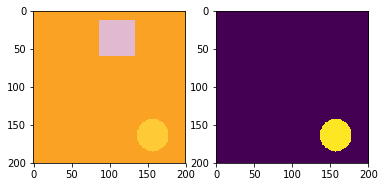

In [14]:
#data_id = 20
data_id += 1

image_path = image_paths[data_id]
mask_path = mask_paths[data_id]
class_ids_path = class_ids_paths[data_id]

# Load data
image, mask, class_ids = maskflow.load_data(image_path, mask_path, class_ids_path, config["MAX_OBJECTS"])

# Build inputs
inputs = {}
inputs["images"] = np.expand_dims(image, axis=0)
inputs["original_image_height"] = image.shape[0]
inputs["original_image_width"] = image.shape[1]
inputs["original_image_channel"] = image.shape[2]

# Run prediction
results = predictor(inputs)

# Display results

fig, axs = plt.subplots(ncols=2)
axs[0].imshow(image)
axs[1].imshow(mask[:, :, 0])

true_class = config["CLASS_NAMES"][int(class_ids[0])]
predicted_class = config["CLASS_NAMES"][int(results["class_ids"][0])]

print(f"True class: {true_class}")
print(f"Predicted class: {predicted_class}")
print([f"{config['CLASS_NAMES'][i]}: {p:.2f}" for i, p in enumerate(results["probabilities"][0])])

# Export TensorFlow Model to SavedModel

In [25]:
shutil.rmtree(saved_model_dir, ignore_errors=True)

assets_extra = {"config.yml": str(root_dir / "config.yml")}
tmp_exported_dir = estimator.export_savedmodel(export_dir_base=str(saved_model_dir), serving_input_receiver_fn=serving_input_receiver_fn, assets_extra=assets_extra)

import time; time.sleep(2)

# Move all the files to the parent folder
for fpath in Path(tmp_exported_dir.decode("utf-8")).iterdir():
    shutil.move(str(fpath), saved_model_dir)
shutil.rmtree(tmp_exported_dir)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Mask RCNN Model mode: prediction
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['predict', 'serving_default']
INFO:tensorflow:Restoring parameters from /home/hadim/.data/Neural_Network/Maskflow/Shapes/Logs/Shapes Detector/model.ckpt-600
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b"/home/hadim/.data/Neural_Network/Maskflow/Shapes/SavedModels/Shapes Detector/temp-b'1528653573'/saved_model.pb"


# Package SavedModel to a ZIP file

In [43]:
import zipfile

zip_model_path = root_dir / "SavedModels" / (model_basename.replace(" ", "_") + ".zip")

def zip_dir(root_dir, path_dir, z):
    for fpath in path_dir.iterdir():
        if fpath.is_file():
            zip_path = fpath.relative_to(root_dir)
            z.write(fpath, arcname=zip_path)
        elif fpath.is_dir():
            zip_dir(root_dir, fpath, z)

with zipfile.ZipFile(zip_model_path, "w") as z:
    zip_dir(saved_model_dir, saved_model_dir, z)